In [25]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess


def return_regr_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    Scores = namedtuple("Scores", ["mse", "mae", "rmse", "r2", "evs"])
    return Scores(mse, mae, rmse, r2, evs)


# Function to generate and plot time series, ACF, and PACF
def plot_series_with_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    axes[0].plot(series, label="Time Series")
    axes[0].set_title(f"{title} - Time Series")
    # axes[0].legend()
    plot_acf(series, lags=20, ax=axes[1], title="ACF")
    plot_pacf(series, lags=20, ax=axes[2], title="PACF")
    plt.tight_layout()
    plt.show()


def arima_forecast(train_series, predicted_series, p, d, q):
    """
    Forecasts a time series one timestep at a time using an ARIMA model.

    Parameters:
        train_series (pd.Series or np.array): The time series data for training.
        predicted_series (pd.Series or np.array): The actual series to compare the predictions.
        p (int): The order of the AR component.
        d (int): The order of differencing.
        q (int): The order of the MA component.

    Returns:
        np.array: The forecasted values.
    """
    train_series = np.array(train_series).copy()
    predicted_series = np.array(predicted_series).copy()
    steps = len(predicted_series)
    prediction = np.zeros(steps)

    # Forecast one timestep at a time
    for step in range(steps):
        # Fit the ARIMA model to the current data
        model = ARIMA(train_series, order=(p, d, q))
        model_fitted = model.fit()

        # Predict the next value and store it in prediction
        predicted_next_value = model_fitted.forecast(steps=1)
        prediction[step] = predicted_next_value[0]

        # Append the actual value to the train_series
        actual_next_value = np.array([predicted_series[step]])
        train_series = np.concatenate((train_series, actual_next_value))

    # Return only the forecasted values
    return prediction

# AR Process

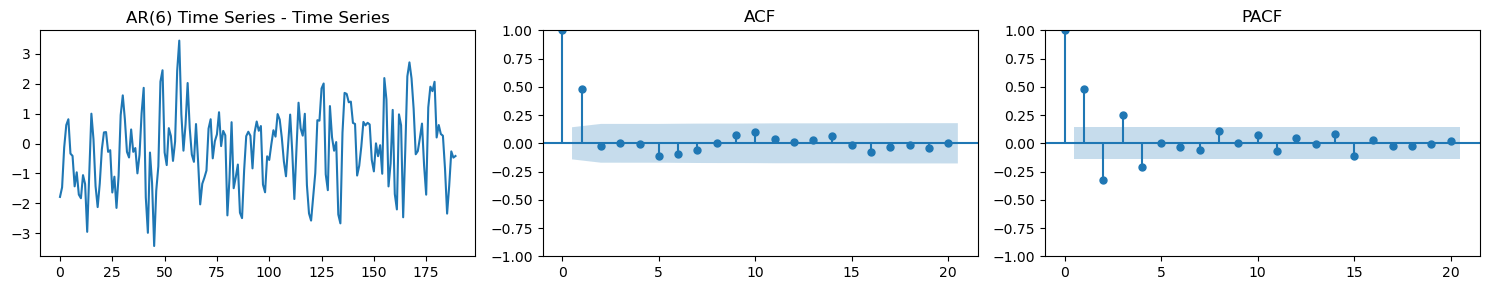

In [26]:
# AR(6): Autoregressive process with six lags
ar6 = ArmaProcess([1, -0.8, 0.6, -0.4, 0.2, -0.1, 0.05], [1]).generate_sample(
    nsample=200
)
ar6_train = ar6[:190]
ar6_test = ar6[190:]
plot_series_with_acf_pacf(ar6_train, "AR(6) Time Series")

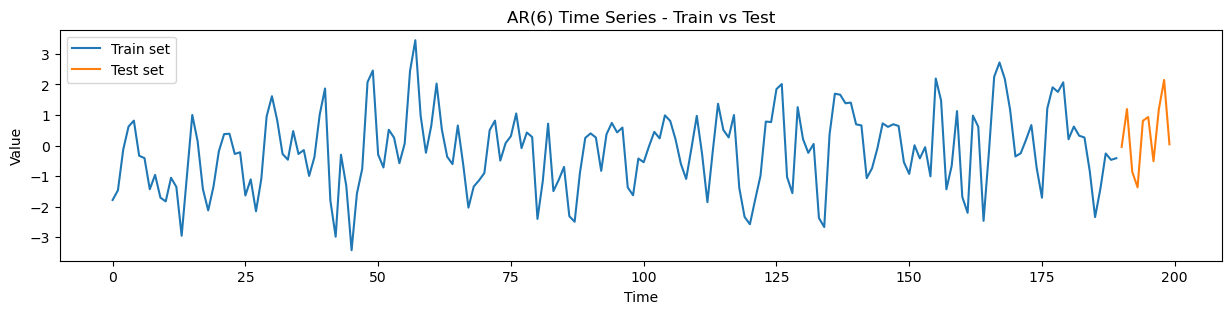

In [27]:
ax = plt.figure(figsize=(15, 3))
plt.plot(range(0, 190), ar6_train, label="Train set")
plt.plot(range(190, 200), ar6_test, label="Test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("AR(6) Time Series - Train vs Test")  
plt.legend()
plt.show()

### Step 1: Check for stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller

# H0: a unit root is present (not stationary) 
# Ha: a unit root is not present (stationary)

result = adfuller(ar6_train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -6.8379832411551735
p-value: 1.8217098267428934e-09


Here the p-value < 0.05, meaning that we can reject H0 (the series is not stationary). Therefore, the series is stationary.

### Step 2: Identify model parameters

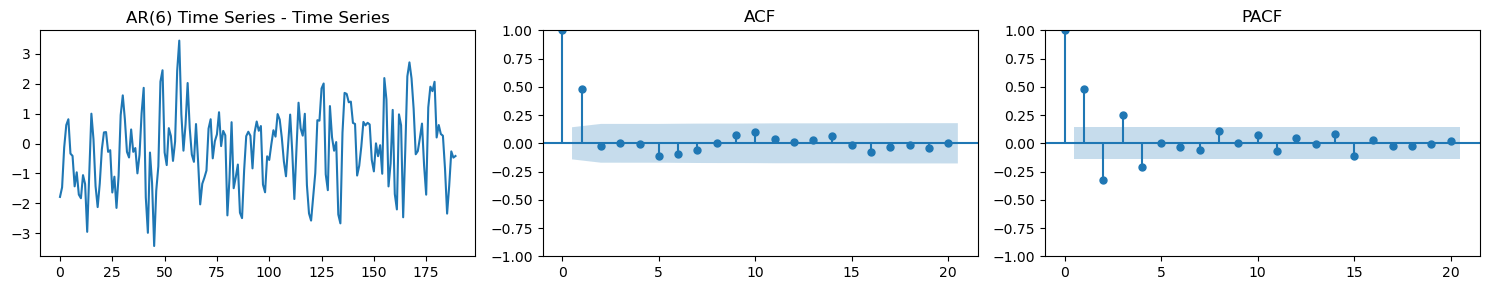

In [29]:
plot_series_with_acf_pacf(ar6_train, "AR(6) Time Series")

- Use PACF to determine the order p for the AR model. -> p = 1
- Use ACF to determine the order q for the MA model. -> q = 1

Surprisingly, the ACF and PACF tell us that the order is one, not six.

### Step 3: Forecasting

In [30]:
forecast_ar = arima_forecast(
    train_series=ar6_train, predicted_series=ar6_test, p=1, d=0, q=0
)
forecast_ma = arima_forecast(
    train_series=ar6_train, predicted_series=ar6_test, p=0, d=0, q=1
)

score_ar = return_regr_score(ar6_test, forecast_ar)
score_ma = return_regr_score(ar6_test, forecast_ma)

print("AR model:", score_ar)
print("MA model:", score_ma)

AR model: Scores(mse=1.3848928556602698, mae=1.0931856836974432, rmse=1.1768147074455986, r2=-0.30656738370657144, evs=-0.2255147068647676)
MA model: Scores(mse=1.0434571238816246, mae=0.8603379223574112, rmse=1.0214974908836656, r2=0.015557746010610551, evs=0.09060878058229138)


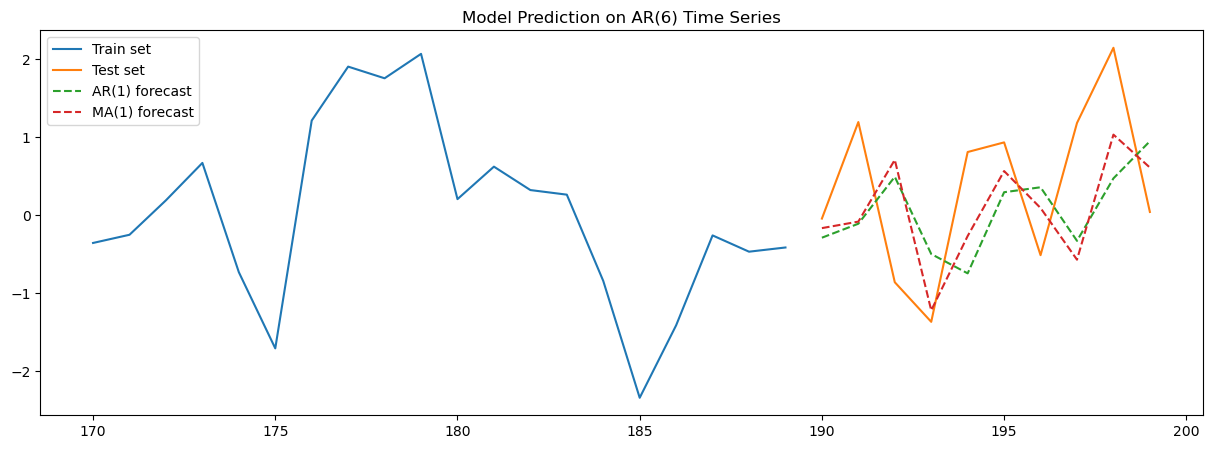

In [31]:
ax = plt.figure(figsize=(15, 5))
plt.plot(range(170, 190), ar6_train[170:190], label="Train set")
plt.plot(range(190, 200), ar6_test, label="Test set")
plt.plot(range(190, 200), forecast_ar, label="AR(1) forecast", linestyle="--")
plt.plot(range(190, 200), forecast_ma, label="MA(1) forecast", linestyle="--")
plt.title("Model Prediction on AR(6) Time Series")
plt.legend()
plt.show()

As we can see, MA model is surprisingly better at predicting AR process compared to AR model itself!

Here are a few potential reasons why the MA model perform better:

- Model Mis-specification: If the AR model is not specified correctly (e.g., the value of p is too low or the AR component doesn't fully capture the autocorrelation), the MA model might still capture enough of the underlying patterns, especially in the presence of noise.
- Noise in the Data: If the series contains a significant amount of noise or randomness, the MA model may do a better job of handling the noise and providing a smoother forecast.
- Overfitting the AR Model: The AR model might be overfitting the noise in the data, leading to poorer generalization, while the MA model might generalize better by focusing more on the average behavior of the series.